#### This notebook is post-processing curvature points to extract the approximate location of the corners.

The information extracted from the curvature is noisy. The goal is to group the noisy points into regions, where approximately the corners are.

In [427]:
import pandas as pd
import numpy as np

In [428]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

First we will read the curvature points that we have extracted using Paraview. They are stored in a .csv file.

In [429]:
points = pd.read_csv("/Users/valentina/projects/cornea_project/Lepto/processed/thesholded_curvature.csv")

We will extract curvature only for a specific range so that we get the corners.

In [430]:
# old version 0.04 - 0.05
# 0.037 - 0.05 cannot finish in spectral clustering
points.Gauss_Curvature.max()
points_subset = points[points['Gauss_Curvature'].between(0.03,0.05)]
# points_subset = points[points['Gauss_Curvature'].between(0.0,10)]

In [431]:
points_subset.head()

,Normals:0,Normals:1,Normals:2,Gauss_Curvature,Points:0,Points:1,Points:2
15,-0.023593,0.22020,0.97517,0.045961,635.0,687.0,11.9
22,0.289240,0.37470,-0.88087,0.031365,468.2,423.0,13.0
30,-0.152880,-0.36779,-0.91726,0.032787,684.0,454.9,14.0
31,-0.173090,-0.35505,-0.91869,0.040997,683.8,455.0,14.0
42,0.063596,0.38158,0.92215,0.047311,643.0,686.0,14.5


#### Visualization with Plotly

Let's visualize the curvature points. For that we will use [Plotly](https://plot.ly/).

In [432]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

In [433]:
# plotly requires the notebook mode
%matplotlib notebook

In [434]:
# creating a colormap which can distinguish separate clusters
num = 200
x3 = np.linspace(-0.5,1,num) + (0.5 - np.random.rand(num))

In [435]:
trace_curv = go.Scatter3d(x=points_subset["Points:1"], y=points_subset["Points:0"],z=points_subset["Points:2"][::-1],
                         showlegend=False,
                         mode='markers',
                         marker=dict(
                                size=3,
                                color=points_subset['Gauss_Curvature'].astype(np.float),
                                colorbar = go.ColorBar(dict(title="")),
                                colorscale='Viridis',
                                line=dict(color='black', width=1)))

In [436]:
scene = dict(
    aspectmode = 'data',
    camera = dict(
    up=dict(x=1, y=0, z=0),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=-0.1, y=-0.0, z=1.5)
    ),
    xaxis=dict(
        range=[0, 1000],
        title='x',
        gridcolor='rgb(255, 255, 255)',
        zerolinecolor='rgb(255, 255, 255)',
        showbackground=True,
        backgroundcolor='rgb(230, 230,230)',
        showticklabels=False, ticks=''
    ),
    yaxis=dict(
        range=[0, 1150],
        title='y',
        gridcolor='rgb(255, 255, 255)',
        zerolinecolor='rgb(255, 255, 255)',
        showbackground=True,
        backgroundcolor='rgb(230, 230,230)',
        showticklabels=False, ticks=''
    ),
    zaxis=dict(
        range=[0,400],
        title='z',
        gridcolor='rgb(255, 255, 255)',
        zerolinecolor='rgb(255, 255, 255)',
        showbackground=True,
        backgroundcolor='rgb(230, 230,230)',
        showticklabels=False, ticks=''
    )
)

In [437]:
fig = tools.make_subplots(rows=1, cols=1,
                          print_grid=False,
                          specs=[[{'is_3d': True}]])

In [438]:
fig.append_trace(trace_curv,1,1)
fig['layout'].update(title = "Gaussian Curvature")
fig['layout']['scene1'].update(scene)

In [439]:
py.iplot(fig,filename='curvature')

### Nearest Neighbor Graph and Spectral Clustering

In [440]:
# from sklearn.neighbors import RadiusNeighborsClassifier
# radius_nbrs = RadiusNeighborsClassifier(radius=1.0)
# radius_nbrs.radius_neighbors_graph(X)

#### Radius Nearest Neighbors

The radius nearest neighbors might be a better choice in this case. 

In [441]:
from sklearn.neighbors import radius_neighbors_graph
G = radius_neighbors_graph(X,5,mode='connectivity',include_self=True)
print(G.shape)
G.toarray()

(5672, 5672)


array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

The connectivity matrix is big but mainly contains zeros and ones. Spectral Clustering has different methods to solve the linear algebra problem:
* it can accept a precomputed sparse matrix
* default 'arpack'
* the 'amg' method is supposed to work well with large and sparse but requires pyamg package installed sometimes returns a numerical error

Let's subset only the coordinate points.

In [442]:
X = points_subset[["Points:0","Points:1","Points:2"]]

We observe that the points look noisy; there are two main problems:
    
    1. first usually there are more than one points in the neighborhood of a corner (i.e. we have points in the region with curvature withing this range)
    
    2. second, the points belong to two surfaces that have been extracted by the surface extraction algorithm (the one below the lenses and the one above the lenses)

#### DBSCAN Clustering

To address the first problem, we will cluster the points, with the hope that individual clusters correspond to the same corner reagion. Then we can use the center of that cluster as an estimate of a corner. We will use the DBSCAN clustering algorithm. The DBSCAN clustering algorithm relies on the density of the points to discover cluster and deals well with outliers so it is appropriate in this case.

In [443]:
from sklearn.cluster import DBSCAN

In [444]:
db = DBSCAN(eps=5, min_samples=2).fit(X)

In [445]:
labels = db.labels_

In [446]:
str(labels)

'[  -1   -1    0 ..., 1327   -1   -1]'

In [447]:
# Lets create new labels which will have distinct colors when plotted
distinct_labels = []
for label in labels:
    distinct_labels.append(label%256)

The negative ones in the labels correspond to outliers. We need to decide whether to exclude those, for now we keep them. Let's visualize the results.

In [448]:
trace_clust = go.Scatter3d(x=points_subset["Points:1"], y=points_subset["Points:0"],z=points_subset["Points:2"],
                         showlegend=False,
                         mode='markers',
                         marker=dict(
                                size=3,
                                color=np.array(distinct_labels).astype(np.float),
                                colorscale='Rainbow',
                                line=dict(color='black', width=1)))

In [449]:
fig = tools.make_subplots(rows=1, cols=1,
                          print_grid=False,
                          specs=[[{'is_3d': True}]])
fig.append_trace(trace_clust,1,1)
fig['layout'].update(title = "DBSCAN Clustering")
fig['layout']['scene1'].update(scene)
py.iplot(fig,filename='db_clustering')

We can see that small clusters have same color.

In [450]:
# total number of clusters
print('The total number of clusters is '+str(len(np.unique(labels)))+'.')

The total number of clusters is 1329.


Let's display only the centers of the clusters.

The approach to extract them is as follows:
* create an extra column containing the labels
* group by that column
* average the coordinates per each group

In [451]:
points_subset['label'] = labels

/Users/valentina/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [452]:
# group by label
grouped_points = points_subset.groupby('label').mean()

In [453]:
# the label is in the index
grouped_points.head()

,Normals:0,Normals:1,Normals:2,Gauss_Curvature,Points:0,Points:1,Points:2
label,,,,,,,
-1,-0.007766,-0.055294,0.204687,0.036722,604.907031,437.633205,108.557271
0,-0.162985,-0.361420,-0.917975,0.036892,683.900000,454.950000,14.000000
1,0.029140,-0.429430,-0.892460,0.031858,459.460000,446.000000,16.000000
2,0.357968,-0.080959,-0.781416,0.040650,457.572000,293.800000,17.439400
3,0.078603,-0.207668,-0.946018,0.043528,711.400000,352.600000,17.206600


In [454]:
# need to exclude the outliers -1 class (should not average over those)

In [455]:
# matplotlib visualization

<IPython.core.display.Javascript object>


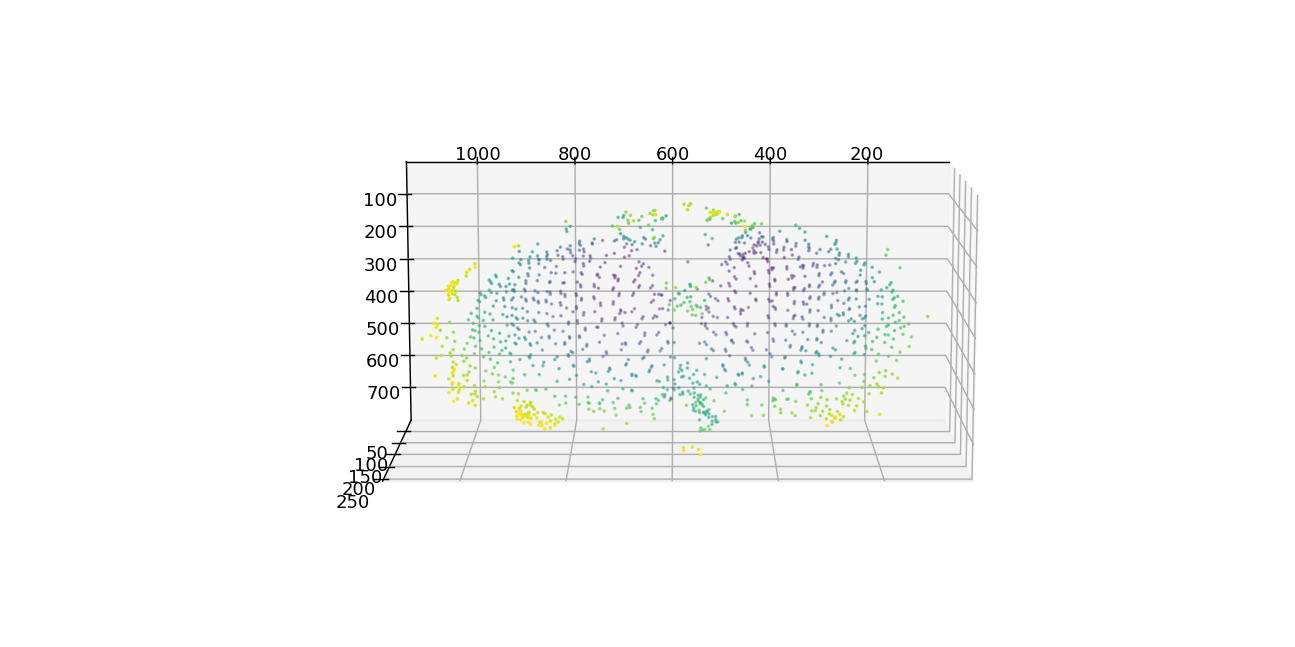

In [456]:
# from mpl_toolkits.mplot3d import Axes3D
% matplotlib notebook
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(grouped_points["Points:0"],grouped_points["Points:1"],grouped_points["Points:2"], s=1, c=grouped_points.index)
ax.view_init(100, 90)
plt.show()

In [457]:
# change distinct labels to labels created by clustering the normals
distinct_labels = []
for label in labels:
    if label==0:
        distinct_labels.append("red")
    else:
        distinct_labels.append("blue")

In [458]:
# plotly visualization

In [460]:
fig = tools.make_subplots(rows=1, cols=1,
                          print_grid=False,
                          specs=[[{'is_3d': True}]])
fig.append_trace(trace_db,1,1)
fig['layout'].update(title = "DBScan Clusters")
fig['layout']['scene1'].update(scene)
py.iplot(fig,filename='db_clustering')

In [461]:
distinct_labels = []
for label in grouped_points.index:
    distinct_labels.append(label%256)

In [462]:
trace_centers = go.Scatter3d(x=grouped_points["Points:1"], y=grouped_points["Points:0"],z=grouped_points["Points:2"],
                         showlegend=False,
                         mode='markers',
                         marker=dict(
                                size=3,
                                color=np.array(distinct_labels).astype(np.float),
                                colorscale='Rainbow',
                                line=dict(color='black', width=1)))

In [463]:
trace_centers = go.Scatter3d(x=grouped_points["Points:1"], y=grouped_points["Points:0"],z=grouped_points["Points:2"][::-1],
                         showlegend=False,
                         mode='markers',
                         marker=dict(
                                size=3,
                                line=dict(color='black', width=1)))

In [464]:
fig = tools.make_subplots(rows=1, cols=1,
                          print_grid=False,
                          specs=[[{'is_3d': True}]])
fig.append_trace(trace_centers,1,1)
fig['layout'].update(title = "Centers of DBScan Clusters")
fig['layout']['scene1'].update(scene)
py.iplot(fig,filename='db_centers')

#### Clustering Normals for Surface Separation

We hope that normals on the two different surfaces will have different orientations, so it will be possible to cluster them in two groups, each containing the normals corresponding to the points on different surfaces.

<IPython.core.display.Javascript object>


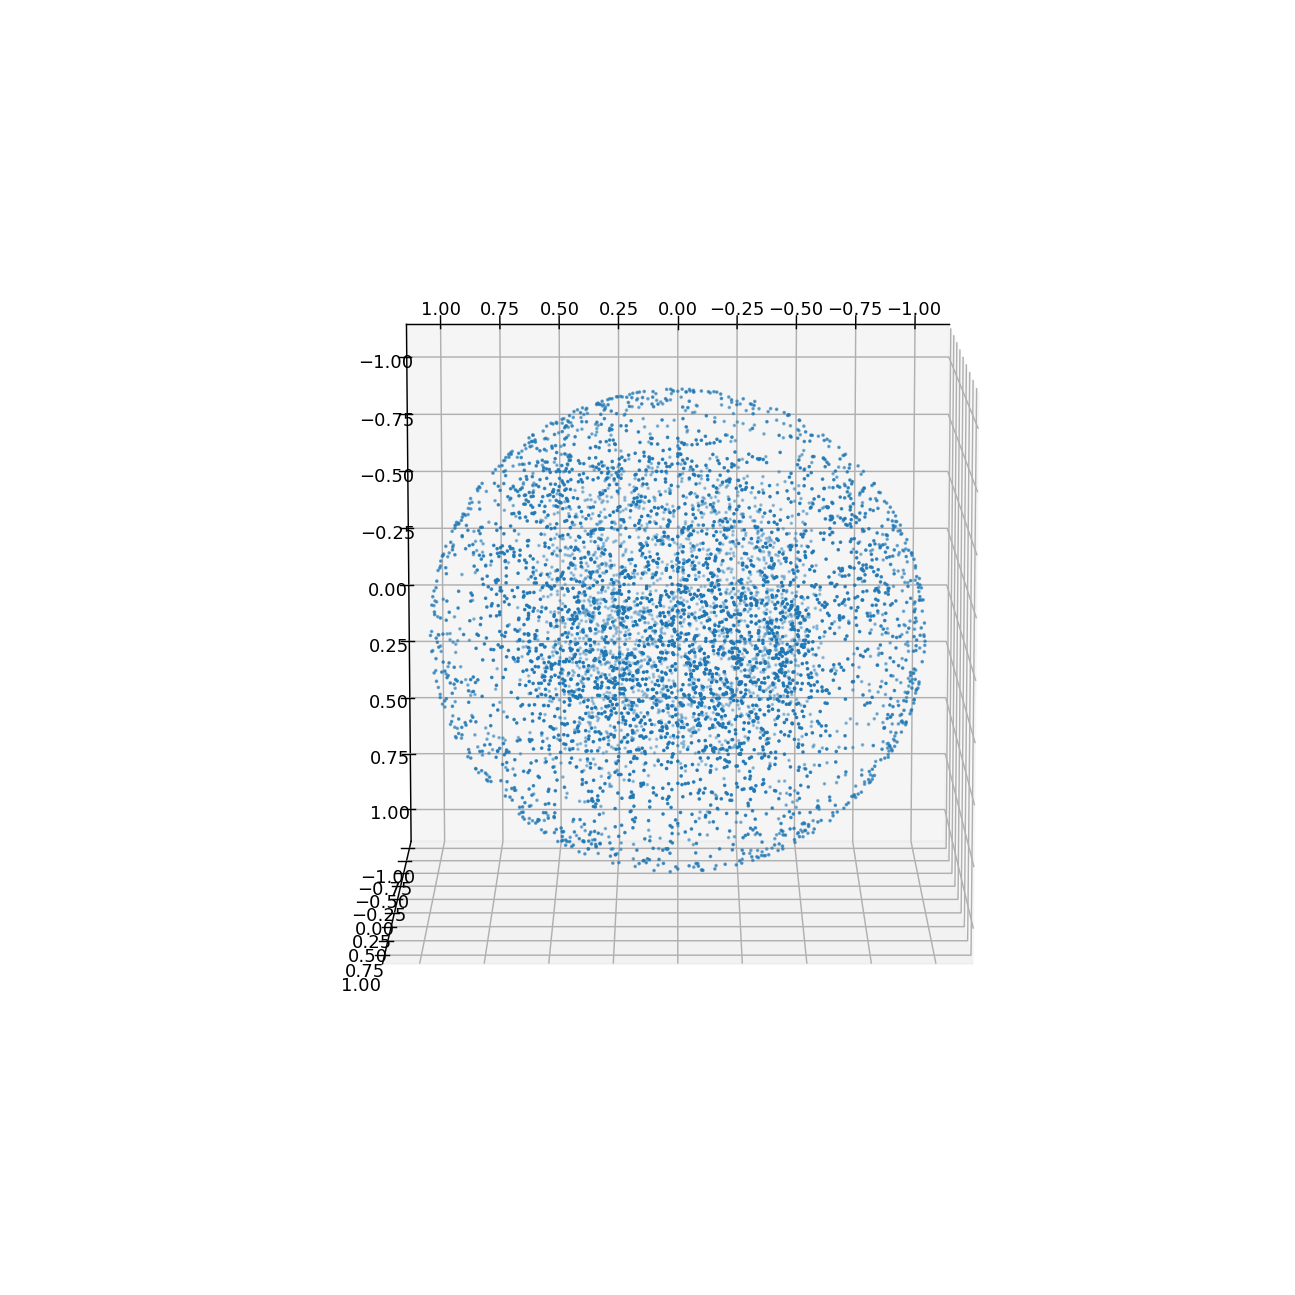

In [465]:
# visualize the normals as points in 3D (clearly they will lie on the sphere):

% matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_subset["Normals:0"],points_subset["Normals:1"],points_subset["Normals:2"], s=1)
ax.view_init(100, 90)
plt.show()
plt.draw()

They are all normalized.This means that some of them are really small and noisy, but they equally matter in the above presentation. 

As previously, we will only look at normals at the corner points. For that we will use `points_subset` variable.

Let's average the normals by group.

In [466]:
grouped_points.head()

,Normals:0,Normals:1,Normals:2,Gauss_Curvature,Points:0,Points:1,Points:2
label,,,,,,,
-1,-0.007766,-0.055294,0.204687,0.036722,604.907031,437.633205,108.557271
0,-0.162985,-0.361420,-0.917975,0.036892,683.900000,454.950000,14.000000
1,0.029140,-0.429430,-0.892460,0.031858,459.460000,446.000000,16.000000
2,0.357968,-0.080959,-0.781416,0.040650,457.572000,293.800000,17.439400
3,0.078603,-0.207668,-0.946018,0.043528,711.400000,352.600000,17.206600


<IPython.core.display.Javascript object>


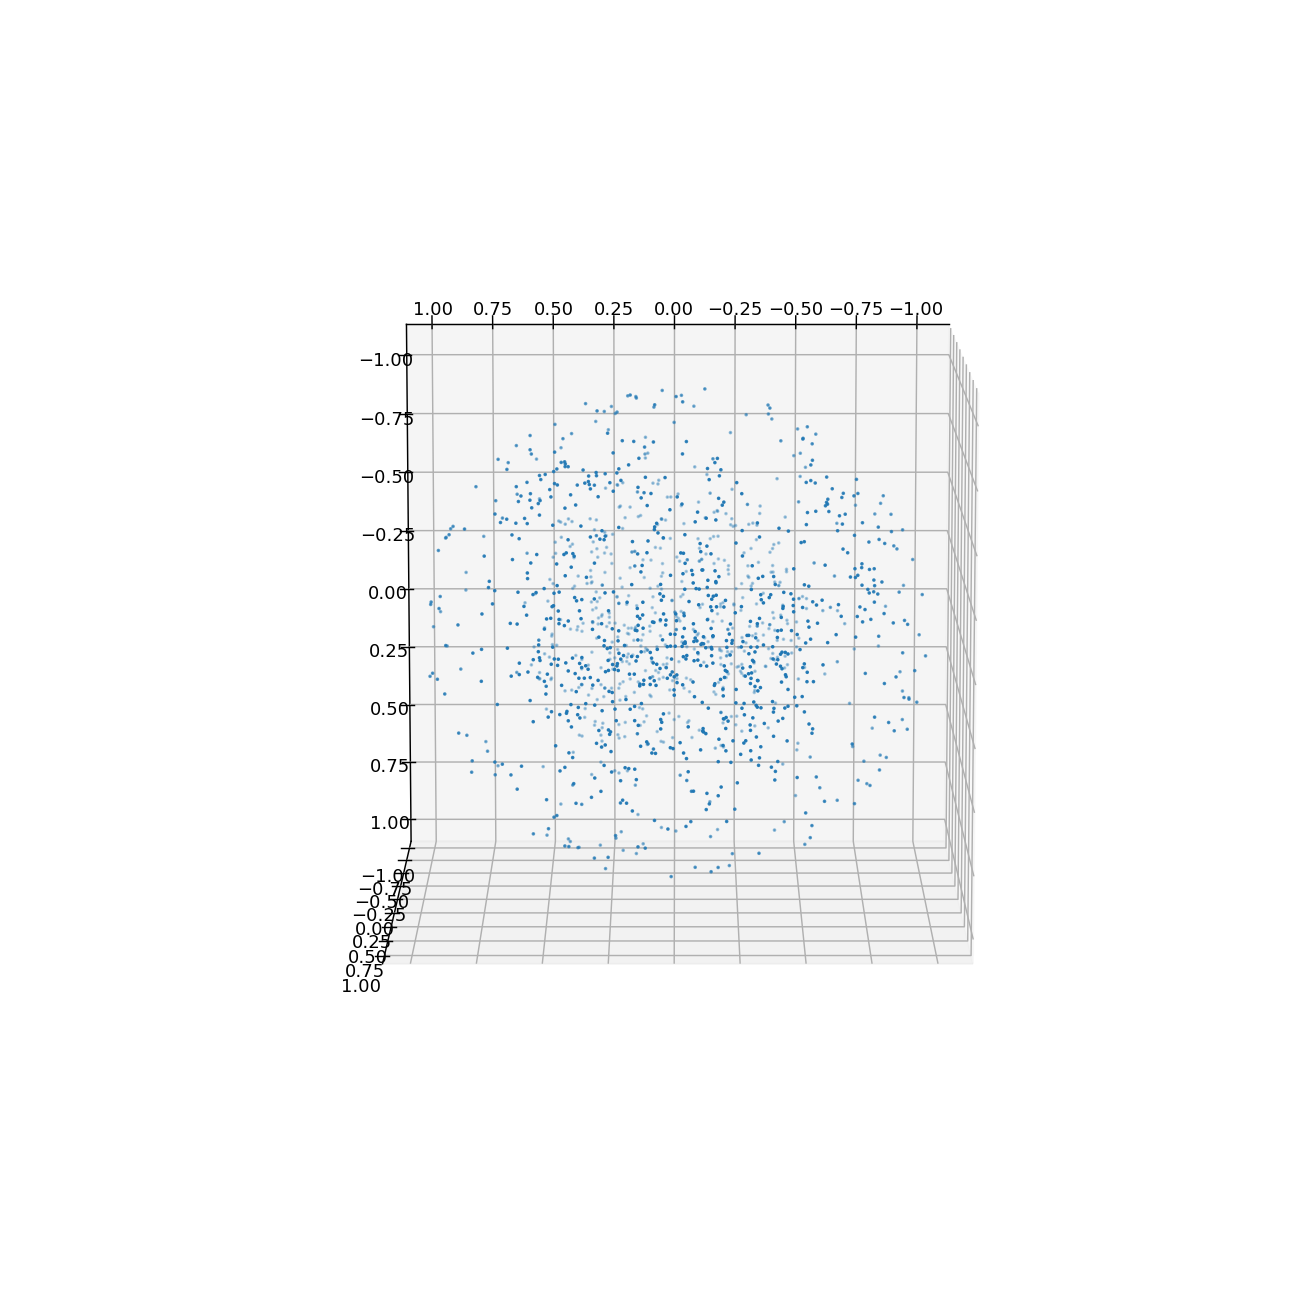

In [467]:
# visualize the normals as points in 3D, these are the grouped normals so they are much sparsers and easier to interpret:


% matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(grouped_points["Normals:0"],grouped_points["Normals:1"],grouped_points["Normals:2"], s=1)
ax.view_init(100, 90)
plt.show()
plt.draw()

We will treat the normals as points in Euclidean space, and will cluster them using the K-Means algorithm.

<IPython.core.display.Javascript object>


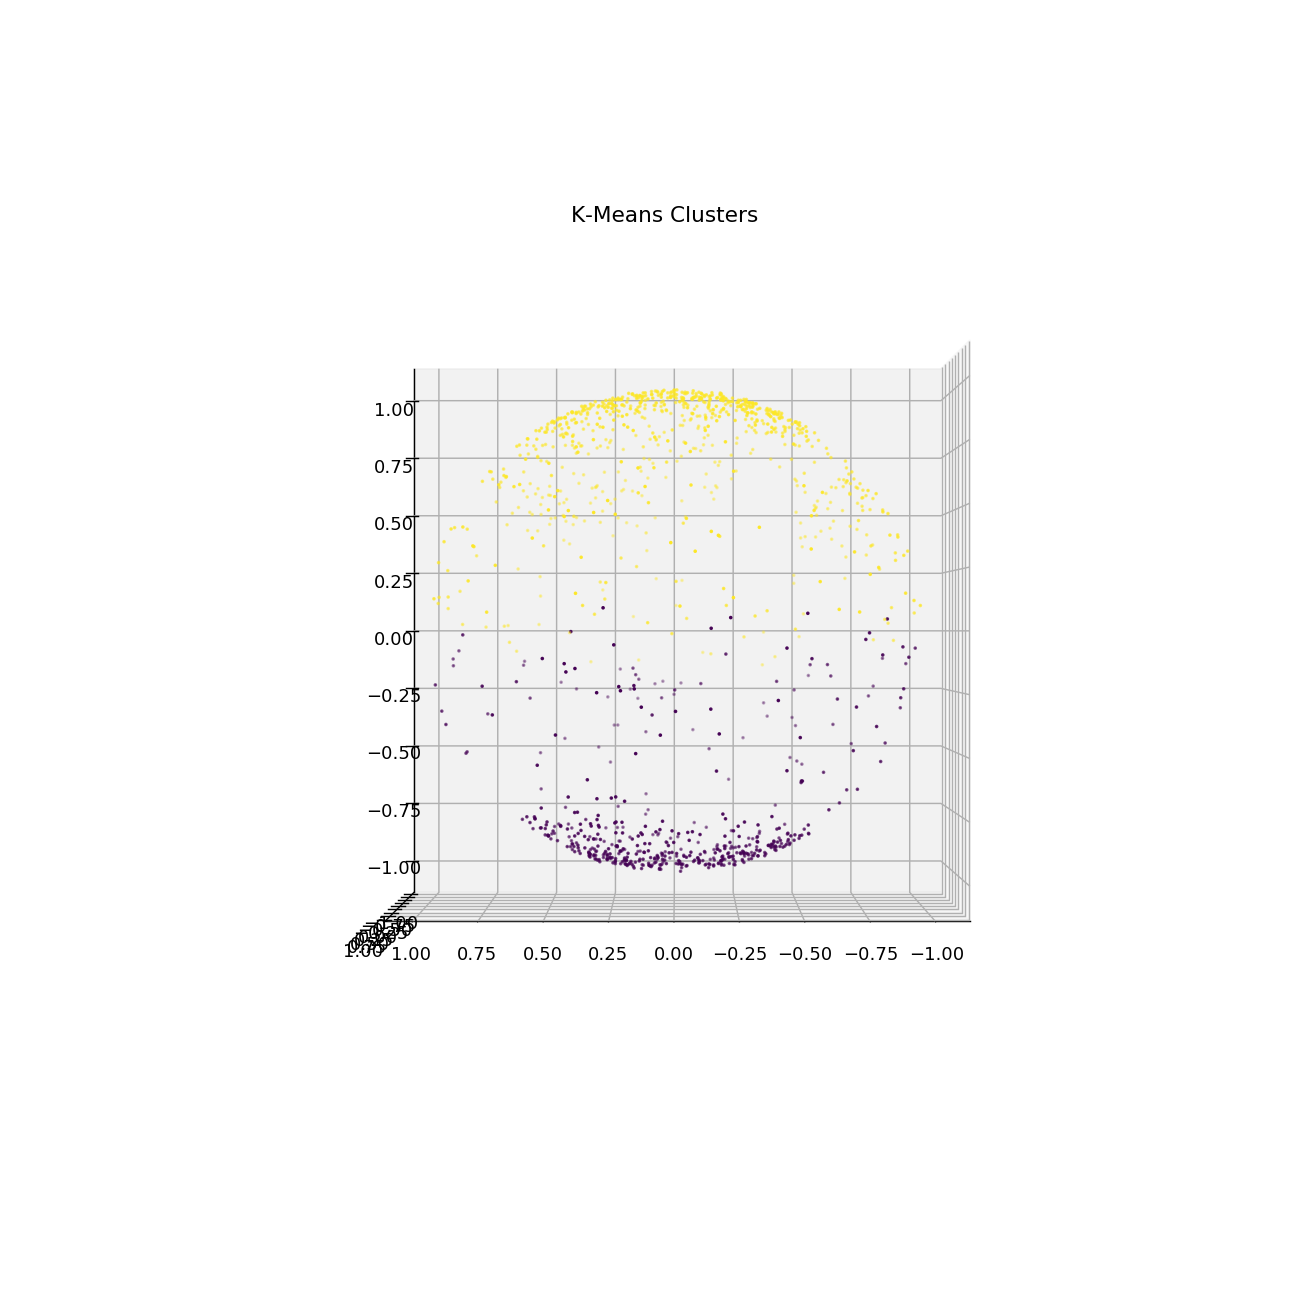

In [468]:
# run kmeans on the normals:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 2,random_state=0).fit(grouped_points.iloc[:,:3])
surf_labels = kmeans.labels_
# kmeans clustering
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.array(grouped_points["Normals:0"]), np.array(grouped_points["Normals:1"]),np.array(grouped_points["Normals:2"]), s=1,c = surf_labels)
plt.autoscale(enable=True, axis='both',tight=True)
ax.set_aspect('equal','box')
ax.view_init(0,90)
plt.title('K-Means Clusters')
plt.show()

Ok, they look well separated. Now let's plot the original points with separation.

<IPython.core.display.Javascript object>


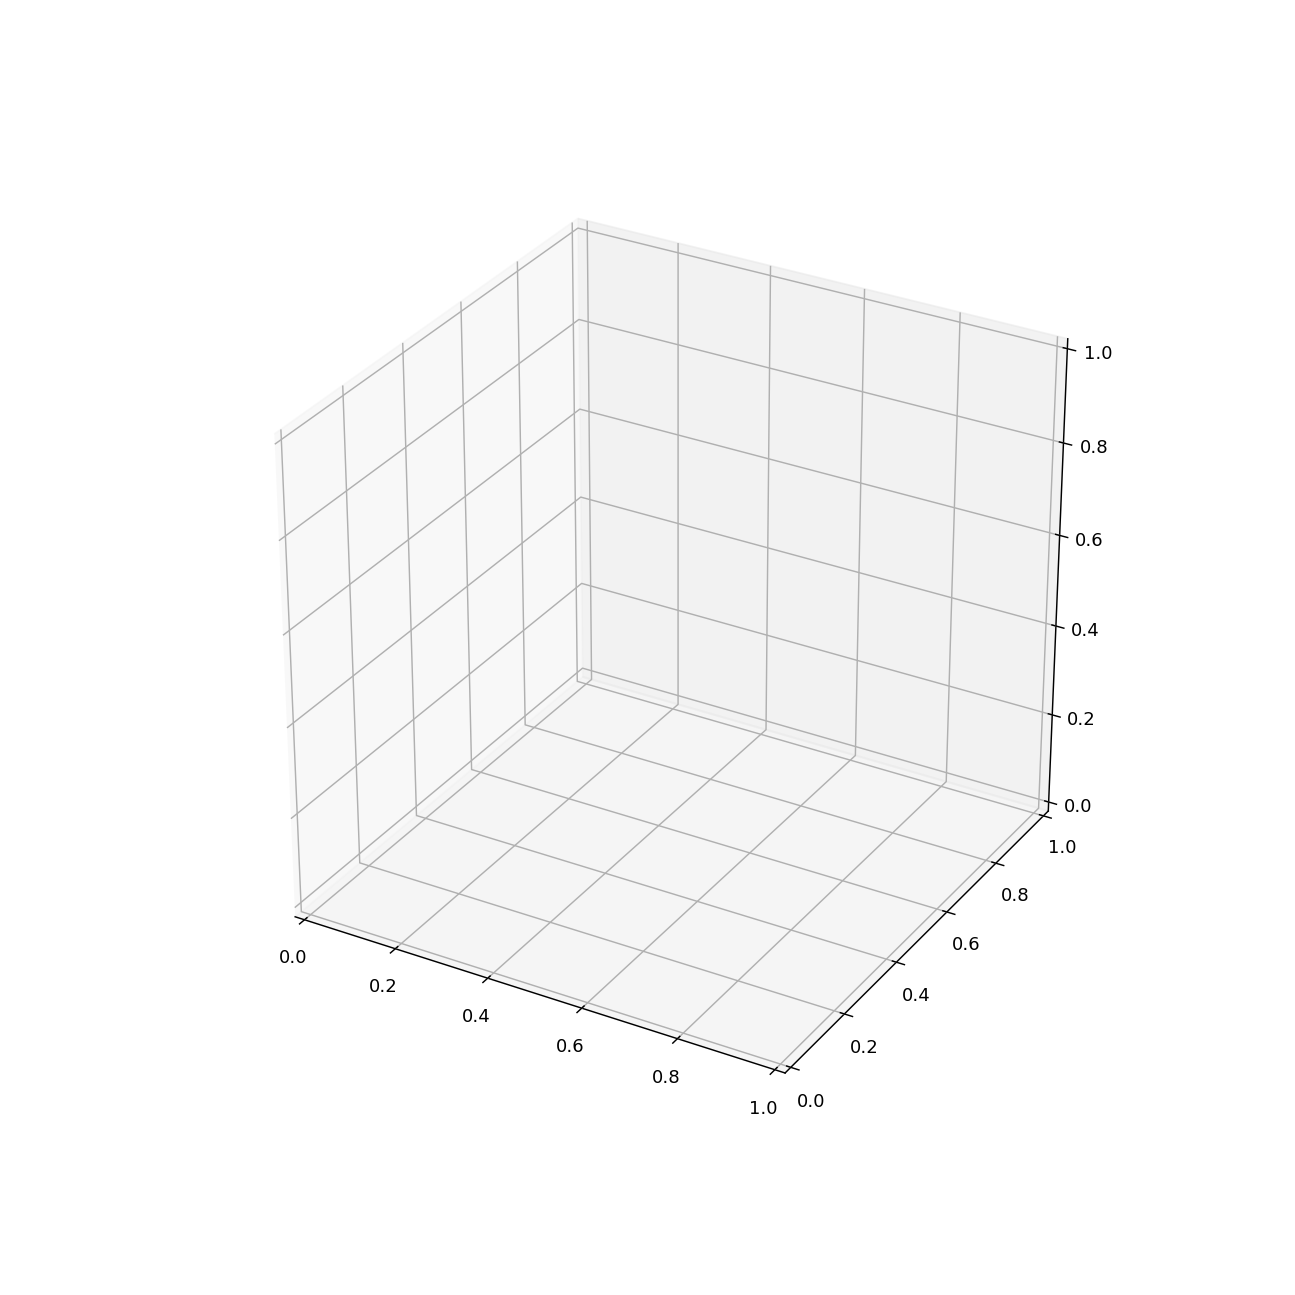

ValueError: Invalid RGBA argument: -1

In [469]:
# kmeans clustering
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.array(grouped_points["Points:0"]), np.array(grouped_points["Points:1"]),np.array(grouped_points["Points:2"]), s=1, cmap = 'viridis',c = labels)
plt.autoscale(enable=True, axis='both',tight=True)
ax.set_aspect('equal','box')
ax.view_init(100, 90)
plt.title('K-Means Clusters')
plt.show()

In [334]:
trace_centers = go.Scatter3d(x=grouped_points["Points:1"], y=grouped_points["Points:0"],z=grouped_points["Points:2"],
                         showlegend=False,
                         mode='markers',
                         marker=dict(
                                size=3,
                                colorscale='Rainbow',
                                line=dict(color='black', width=1)))

Yay, the normals helped us separate the surfaces! Now we can plot the upper layer points individually.

In [345]:
# change distinct labels to labels created by clustering the normals
distinct_labels = []
for label in surf_labels:
    if label==0:
        distinct_labels.append("red")
    else:
        distinct_labels.append("blue")


In [346]:
labels

array([  -1,   -1,    0, ..., 1327,   -1,   -1])

In [381]:
trace_centers = go.Scatter3d(x=grouped_points["Points:1"], y=grouped_points["Points:0"],z=grouped_points["Points:2"][::-1],
                         showlegend=False,
                         mode='markers',
                         marker=dict(
                                size=3,
                                color=distinct_labels,
                                #colorscale='Rainbow',
                                line=dict(color='black', width=1)))

In [382]:
 fig = tools.make_subplots(rows=1, cols=1,
                          print_grid=False,
                          specs=[[{'is_3d': True}]])
fig.append_trace(trace_centers,1,1)
fig['layout'].update(title = "Surface Separation")
fig['layout']['scene1'].update(scene)
py.iplot(fig,filename='surface_separation')

Now let's extract the outer surface.

In [383]:
# subsetting the points of the outer surface
points_out = np.array(grouped_points)[~surf_labels.astype('bool'),:]

In [384]:
# change distinct labels to labels created by clustering the normals
trace_centers = go.Scatter3d(x=points_out[:,5], y=points_out[:,4],z=points_out[:,6][::-1],
                         showlegend=False,
                         mode='markers',
                         marker=dict(
                                size=3,
                                color="red",
                                #colorscale='Rainbow',
                                line=dict(color='black', width=1)))

In [385]:
fig = tools.make_subplots(rows=1, cols=1,
                          print_grid=False,
                          specs=[[{'is_3d': True}]])
fig.append_trace(trace_centers,1,1)
fig['layout'].update(title = "Outer Surface")
fig['layout']['scene1'].update(scene)
py.iplot(fig,filename='outer_surface')

### Create the graph

Now maybe we should find closest three members?

But we want them of the same distance.

* Find first three neigbors
* Calculate distances (we have the distances ranked)
* If some distance is bigger by a threshold from the other distances, do not create an edge, otherwise, connect

Matrix of distance

In [386]:
# finding the nearest neighbors
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(points_out[:,4:])
distances, indices = nbrs.kneighbors(points_out[:,4:])

In [387]:
# creating the nearest neighbor graph
G = nbrs.kneighbors_graph(points_out[:,4:], mode='distance').toarray()

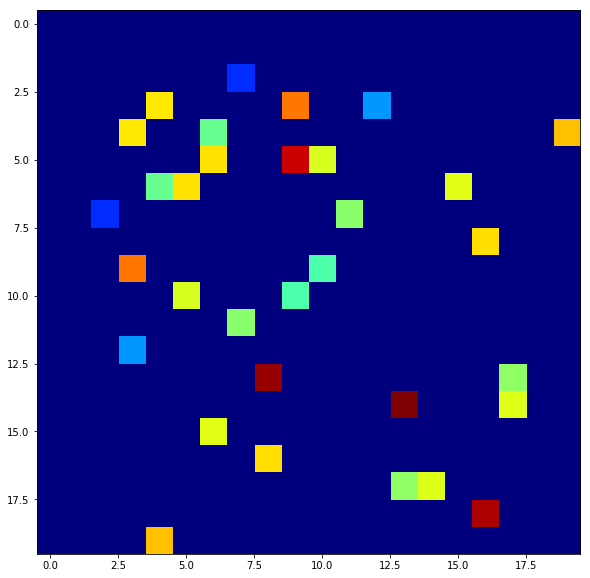

In [388]:
%matplotlib inline
plt.figure(figsize = (10,10))
plt.imshow(G[:20,:20],cmap = 'jet')

In [389]:
points_out.shape

(529, 7)

In [390]:
nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(points_out[:,4:])
distances, indices = nbrs.kneighbors(points_out[:,4:])

(-0.5, 528.5, 2.5, -0.5)

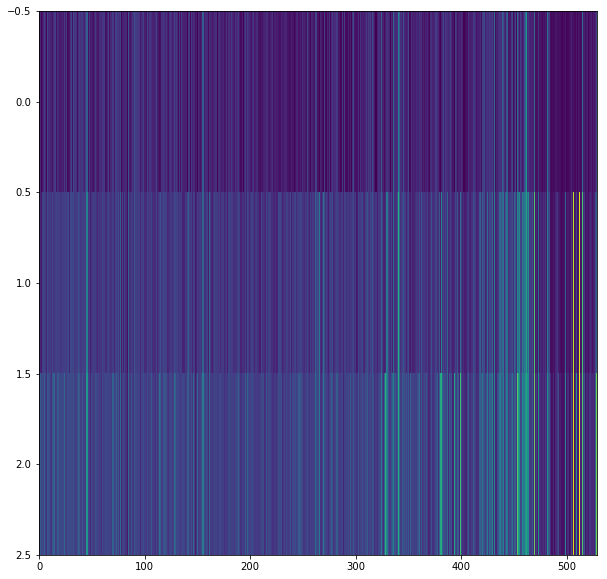

In [391]:
plt.figure(figsize = (10,10))
plt.imshow(distances[:,1:].T)
plt.axis('tight')


array([[  683.9       ,   454.95      ,    14.        ],
       [  459.46      ,   446.        ,    16.        ],
       [  457.572     ,   293.8       ,    17.4394    ],
       ..., 
       [  890.3225    ,   622.9725    ,   241.5       ],
       [  967.94333333,   207.83333333,   241.66666667],
       [ 1053.36666667,   399.66666667,   241.66666667]])

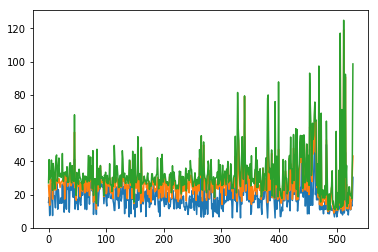

In [392]:
plt.figure()
plt.plot(distances[:,1:])
points_out[:,4:]

In [393]:
distances

array([[  0.        ,  15.4247084 ,  25.81756155,  27.1371517 ],
       [  0.        ,  18.41172615,  19.0139519 ,  41.13455465],
       [  0.        ,   7.48314649,  13.64291929,  29.40250841],
       ..., 
       [  0.        ,  13.10702298,  16.95926461,  17.60254989],
       [  0.        ,  16.90856501,  33.81144123,  42.3788543 ],
       [  0.        ,  30.44946633,  43.2891698 ,  98.67380183]])

In [394]:
indices

array([[  0,  25,  26,  47],
       [  1,  43,  42,  77],
       [  2,   7,  28,  89],
       ..., 
       [526, 518, 510, 505],
       [527, 504, 491, 492],
       [528, 509, 499, 467]])

In [395]:
def create_edges(points, distances):
    # if any of the distances is twice as large as the other two distances call outlier and remove the edge
    # maybe I can use to check if they satisfy the triangle inequality
    # my distances are sorted
    
    idx = (distances[:,6]>distances[:,4]+distances[:,5])
    indices[idx,[0,3]]
    

In [396]:
distances.shape

(529, 4)

In [397]:
import networkx as nx

In [398]:
# need 4 neighbors because it includes self, once I specify the mode connectivity, it does not accept the argument include_self.
G = nbrs.kneighbors_graph(points_out[:,4:], n_neighbors = 4, mode='connectivity')
G 

<529x529 sparse matrix of type '<class 'numpy.float64'>'
	with 2116 stored elements in Compressed Sparse Row format>

In [399]:
# G_nx = nx.from_numpy_matrix(G)
G_nx = nx.from_scipy_sparse_matrix(G)

In [400]:
pos_dict = {}
for n, pos in zip(range(points_out.shape[0]),list(zip(points_out[:,4],points_out[:,5],points_out[:,6]))):
    pos_dict[n] = pos

In [401]:
nx.set_node_attributes(G_nx,'pos',pos_dict)

In [422]:
# creating function to plot networkx graphs
import plotly.offline as py
from plotly.offline import init_notebook_mode
from plotly.graph_objs import Scatter3d, Figure, Layout, Line, Marker, Data, XAxis, YAxis, ZAxis
init_notebook_mode(connected=True)


import networkx as nx

def plot_graph(G):

    pos_dict_small = []

    #for item in G.nodes():
    #    pos_dict_small[item] = pos_dict[item]
    #nx.set_node_attributes(G,'pos',pos_dict)
    pos=nx.get_node_attributes(G,'pos')

    dmin=1
    ncenter=0
    for n in pos:
        x,y,z=pos[n]
        y,x,z = x,y,z
        d=(x-0.5)**2+(y-0.5)**2+(z-0.5)**2
        if d<dmin:
            ncenter=n
            dmin=d

# p=nx.single_source_shortest_path_length(G,ncenter)


    edge_trace = Scatter3d(
        x=[],
        y=[],
        z=[],
        line=Line(width=0.5,color='#888'),
        hoverinfo='none',
        mode='lines')

    for edge in G.edges():
        x0, y0, z0 = G.node[edge[0]]['pos']
        x1, y1, z1 = G.node[edge[1]]['pos']
        edge_trace['y'] += [x0, x1, None]
        edge_trace['x'] += [y0, y1, None]
        edge_trace['z'] += [z0, z1, None]

    node_trace = Scatter3d(
        x=[],
        y=[],
        z=[],
        text=[],
        mode='markers',
        hoverinfo='text',
        marker=Marker(
            showscale=True,
            # colorscale options
            # 'Greys' | 'Greens' | 'Bluered' | 'Hot' | 'Picnic' | 'Portland' |
            # Jet' | 'RdBu' | 'Blackbody' | 'Earth' | 'Electric' | 'YIOrRd' | 'YIGnBu'
            colorscale='YIGnBu',
            reversescale=True,
            color=colors,
            size=5,
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
            line=dict(width=2)))

    for node in G.nodes():
        x, y, z = G.node[node]['pos']
        x, y, z = y, x, z
        node_trace['x'].append(x)
        node_trace['y'].append(y)
        node_trace['z'].append(z)

    for node, adjacencies in enumerate(G.adjacency_list()):
        node_trace['marker']['color'].append(len(adjacencies))
        node_info = '# of connections: '+str(len(adjacencies))
        node_trace['text'].append(node_info)

    
    fig = Figure(data=Data([edge_trace, node_trace]),
                 layout=Layout(
                    #width = 1000,
                    #height = 500,
                    scene = dict(
                    aspectmode = 'data',
                    camera = dict(
                        up=dict(x=1, y=0, z=0),
                        center=dict(x=0, y=0, z=0),
                        eye=dict(x=-0.1, y=-0.0, z=1.5)
                    ),
                    #xaxis = dict(
                    #    nticks=4, range = [0,500],),
                    #yaxis = dict(
                    #    nticks=4, range = [0,500],),
                    #zaxis = dict(
                    #    nticks=4, range = [0,200],),
                    ),
                    autosize = True,
                    title='<br>Network graph made with Python',
                    titlefont=dict(size=16),
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    annotations=[ dict(
                        text="Python code: <a href='https://plot.ly/ipython-notebooks/network-graphs/'> https://plot.ly/ipython-notebooks/network-graphs/</a>",
                        showarrow=False,
                        xref="paper", yref="paper",
                        x=0.005, y=-0.002 ) ],
                    xaxis=XAxis(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=YAxis(showgrid=False, zeroline=False, showticklabels=False)))
    return(fig)

    py.iplot(fig, filename='networkx')

In [423]:
# contains all the 
G_knn = nx.k_nearest_neighbors(G_nx,3)

In [424]:
colors = [int(i % 23) for i in labels]
labels.astype(np.float)

array([ -1.00000000e+00,  -1.00000000e+00,   0.00000000e+00, ...,
         1.32700000e+03,  -1.00000000e+00,  -1.00000000e+00])

In [425]:
fig = plot_graph(G_nx)

In [426]:
py.iplot(fig, filename='knn_graph')

#### Extracting Cycles

Networkx provides functions to extract cycles from a graph. Simple cycles include all paths with the same starting and ending point without repeated nodes or edges along the path. This includes way more cycles than we need, and is quite slow. Also this function does not use the positions of the nodes, i.e. the geometry, so it csnnot look for convex cycles.

In [ ]:
# the simple cycles function 
simple_cycles = nx.simple_cycles(G_nx.to_directed())

In [ ]:
hexagons = []
for cycle in simple_cycles:
    if len(cycle)==6:
        hexagons.append(cycle)
        print(cycle)


In [ ]:
len(hexagons)

In [ ]:
cyc = nx.cycle_basis(G_nx)
hexagons = []
for c in cyc:
    if len(c)==6:
        hexagons.append(c)
len(hexagons)

In [ ]:
cyc = nx.find_cycle(G_nx)
hexagons = []
for c in cyc:
    if len(c)==6:
        hexagons.append(c)
cyc

In [ ]:
# seems there are more hexagons than I can find???
hexagons[0]


In [ ]:
# Create color labels based on cycles:

for h in hexagons:
    

In [ ]:

# removing points
# adding points
# help edgs using the curvature values

In [ ]:
def poly_area(poly):
    if len(poly) < 3: # not a plane - no area
        return 0
    total = [0, 0, 0]
    N = len(poly)
    for i in range(N):
        vi1 = poly[i]
        vi2 = poly[(i+1) % N]
        prod = np.cross(vi1, vi2)
        total[0] += prod[0]
        total[1] += prod[1]
        total[2] += prod[2]
    result = np.dot(total, unit_normal(poly[0], poly[1], poly[2]))
    return abs(result/2)

In [ ]:
def unit_normal(a, b, c):
    x = np.linalg.det([[1,a[1],a[2]],
             [1,b[1],b[2]],
             [1,c[1],c[2]]])
    y = np.linalg.det([[a[0],1,a[2]],
             [b[0],1,b[2]],
             [c[0],1,c[2]]])
    z = np.linalg.det([[a[0],a[1],1],
             [b[0],b[1],1],
             [c[0],c[1],1]])
    magnitude = (x**2 + y**2 + z**2)**.5
    return (x/magnitude, y/magnitude, z/magnitude)

In [ ]:
# area of hexagon cycles
areas = []
for h in hexagons:
    coord = np.array([pos_dict[key] for key in h])
    areas.append(poly_area(coord))
    


In [ ]:
hexagons

In [ ]:
#H = G_nx.subgraph(hexagons[1])
fig = plot_graph(H)
py.iplot(fig)
# when I do a subgraph I get all the original edges, not just the path that the cycle corresponds to. Clearly it might not look planar. But the strange part is is not looking simple either, since we had to remove a lot of edges
# we remove the edges by hand, but there should be a way to reset the edges to the new set of edges.
# so what is a simple cycle?
# just a cycle without repetition of edges and nodes
# that is why there are so many
# I think I really need to work with the cycle bases:
# but they give too few.
# finding repetitive structure: convolutional network same pattern


# color points by cycle

In [ ]:
nx.draw(H)

In [ ]:
hexagons[1]

In [ ]:
H.edges()

In [ ]:
#H.remove_edge(483,483)
H.remove_edge(501,519)
H.remove_edge(517,517)
H.remove_edge(516,516)
H.remove_edge(483,516)
H.remove_edge(483,517)
H.remove_edge(501,501)
H.remove_edge(501,516)
H.remove_edge(501,517)
H.remove_edge(490,490)
H.remove_edge(519,519)
H.remove_edge(516,516)
H.remove_edge(517,517)

In [ ]:
from mayavi import mlab

In [ ]:
print(hexagons[0])


In [ ]:
# maybe visualize somehow the areas which I am computing

cmap = plt.get_cmap('rainbow',len(set(labels)))
colors = [cmap(l) for l in labels]
np.array(colors).shape
colors = [int(i % 23) for i in labels]
labels.astype(np.float)


import matplotlib as mpl

N = 200
cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0,N,N+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
(labels).astype(np.int)
print(len(labels))

labels.shape

In [ ]:
labels = {}
for (n,h) in enumerate(hexagons):
    for node in h:
        labels[node] = n
#!Same nodes belong to different cycles
        
# sorting
import collections
od = collections.OrderedDict(sorted(labels.items()))
print(od.keys())
labels = pd.DataFrame(labels,index=od.keys())
print(labels.shape)
labels.head()
#sorted(labels, key=labels.get)
#labels.items(), key=operator.itemgetter(1))

In [ ]:
# get all the nodes in cycles
nodes = {}
for (n,h) in enumerate(hexagons):
    for node in h:
        labels[node] = "red"
print(labels)

In [ ]:
import collections
od = collections.OrderedDict(sorted(labels.items()))
labels = pd.DataFrame(labels,index=od.keys())
print(labels.shape)
labels.head()
#sorted(labels, key=labels.get)
#labels.items(), key=operator.it

In [ ]:
nodes = set([y for x in hexagons for y in x])
labels = {}
colors = []
for i in range(points_out.shape[0]):
    if i in nodes:
        colors.append("red")
    else:
        colors.append("green")
    

In [ ]:
cmap = plt.get_cmap('rainbow',len(set(labels)))
colors = [cmap(l) for l in labels]
np.array(colors).shape
colors = [int(i % 23) for i in labels]
labels.astype(np.float)

In [ ]:
plt.plot(np.std(distances[:,1:],axis = 1))

In [ ]:
np.median(distances[70,1:])

In [ ]:
# Create a measure to find neighbors
distances

In [ ]:
G = nbrs.kneighbors_graph(X, mode='distance').toarray()

In [ ]:
# finding shortest cycle from a vertex
# find first n cycles ranked by length

In [ ]:
# find shortest simple cycle
# find simple cycle of lenght 6
# ensure it is convex

In [ ]:
G_nx.edges()

In [ ]:
# For each node calculate the angle with each edge


In [ ]:
def atan2_normalized( y, x ):
    angle = atan2( y, x )
    if angle < 0:
        return angle + 2 * Pi
    else:
        return angle

In [ ]:
def node_angle(a,b,c):
    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)

    return(np.degrees(angle))

In [ ]:
len(hexagons)

In [ ]:
hexagons[0]

In [ ]:
node_angle(np.array(pos_dict[hexagons[0][0]]),np.array(pos_dict[hexagons[0][1]]),np.array(pos_dict[hexagons[0][2]]))

In [ ]:
def cycle_angles(cycle):
    angles = []
    for i in list(range(len(cycle)-2)):
        angles.append(node_angle(np.array(pos_dict[cycle[i]]),np.array(pos_dict[cycle[i+1]]),np.array(pos_dict[cycle[i+2]])))
    angles.append(node_angle(np.array(pos_dict[cycle[len(cycle)-2]]),np.array(pos_dict[cycle[len(cycle)-1]]),np.array(pos_dict[cycle[0]])))
    angles.append(node_angle(np.array(pos_dict[cycle[len(cycle)-1]]),np.array(pos_dict[cycle[0]]),np.array(pos_dict[cycle[1]])))
    return(angles)

In [ ]:
cycle_angles(hexagons[2])